#Multilingual-uncased-sentiment

#1. Install and Import Dependincies

In [ ]:
#!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116


In [ ]:
!pip install transformers requests beautifulsoup4 pandas numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.0 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests # make a request to the website we want to scrap
from bs4 import BeautifulSoup # webscrapping, extract the data from the requested webpage
import re

#2. Instantiate Model

In [ ]:
# load the model and the tokenizer
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')



#3.Encode and Calculate Sentiment

In [ ]:
# tokenize the sentence and convert the tokens into list of numbers, that will be used as inputs to BERT model
# BERT expect the sentence to start with [CLS] (encoded into 101) and ended by [SEP] (encoded into 102)

sent_1 = "It was good but couldve been better. Great"
sent_2 = "BERT is trained on and expects sentence pairs, using 1s and 0s to distinguish between the two sentences. "

#encoding the sentences, the tokenizer return a list of lists (encoded sentences)
tokens_sent1 = tokenizer.encode( sent_1, return_tensors='pt')
tokens_sent2 = tokenizer.encode( sent_2, return_tensors='pt')


In [ ]:
tokens_sent1

tensor([[  101, 10197, 10140, 12050, 10502, 12296, 10598, 10662, 16197,   119,
         11838,   102]])

In [ ]:
tokens_sent2

tensor([[  101, 40668, 10127, 32610, 10125, 10110, 11460, 84789, 10107, 45261,
         49361,   117, 13136,   122, 10107, 10110,   121, 10107, 10114, 91884,
         10986, 10103, 10536, 45261, 10107,   119,   102]])

In [ ]:
# decode the tokens list to get the original sentence
tokenizer.decode(tokens_sent1[0])

'[CLS] it was good but couldve been better. great [SEP]'

In [ ]:
# performe sentiment analysis
sentiment1 = model(tokens_sent1)

In [ ]:
sentiment1

SequenceClassifierOutput(loss=None, logits=tensor([[-2.7768, -1.2353,  1.4419,  1.9804,  0.4584]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
# predict the sentiment, the higher the number the better the sentiment
# the answer is 4 that means it is a good review
int(torch.argmax(sentiment1.logits) + 1 )

4

#4. Scraping Data

In [ ]:
#get the text out of the webpage
r = requests.get('https://www.yelp.com/biz/social-brew-cafe-pyrmont')
# pass the page to a beautifulsoup object
soup = BeautifulSoup(r.text, 'html.parser')
#using regex to find any class that contains 'comment' in its name
regex = re.compile('.*more.*')
results = soup.find_all('span', {'class':regex}) # p(tag)
reviews = [result.text for result in results]

In [ ]:
print("The number of extracted reviews is {}".format(len(reviews)))

The number of extracted reviews is 10


In [ ]:
r.text

'<!DOCTYPE html><html lang="en-US" prefix="og: http://ogp.me/ns#" style="margin: 0;padding: 0; border: 0; font-size: 100%; font: inherit; vertical-align: baseline;"><head><script>document.documentElement.className=document.documentElement.className.replace(/\x08no-js\x08/,"js");</script><meta http-equiv="Content-Type" content="text/html; charset=UTF-8" /><meta http-equiv="Content-Language" content="en-US" /><meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no"><link rel="mask-icon" sizes="any" href="https://s3-media0.fl.yelpcdn.com/assets/srv0/yelp_large_assets/b2bb2fb0ec9c/assets/img/logos/yelp_burst.svg" content="#FF1A1A"><link rel="shortcut icon" href="https://s3-media0.fl.yelpcdn.com/assets/srv0/yelp_large_assets/dcfe403147fc/assets/img/logos/favicon.ico"><script> window.ga=window.ga||function(){(ga.q=ga.q||[]).push(arguments)};ga.l=+new Date;window.ygaPageStartTime=new Date().getTime();</script><script>\n            window.yelp = window.yelp || {};\

In [ ]:
results[1]

<span alt="" aria-hidden="true" class="icon--24-more-v2 css-ije6j5" role="img"><svg class="icon_svg" height="24" width="24"><path d="M12 13.5a1.5 1.5 0 100-3 1.5 1.5 0 000 3zm8 0a1.5 1.5 0 100-3 1.5 1.5 0 000 3zm-16 0a1.5 1.5 0 100-3 1.5 1.5 0 000 3z"></path></svg></span>

In [ ]:
# get the text
results[1].text

''

#5. Load Reviews in DataFrame and Score

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.DataFrame(np.array(reviews), columns = ['review'])

In [ ]:
df["review"].iloc[0]

''

In [ ]:
# create a function that reuturn the sentiment score from a given setence  (using the pretrained model)
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [ ]:
sentiment_score(df["review"].iloc[0])

4

In [ ]:
# apply sentiment_score function to all the reviews in the dataset
# the input sequence is limited to 512 tokens
df['sentiment'] = df['review'].apply(lambda x: sentiment_score(x[:512]))

In [ ]:
df

,review,sentiment
0,,4
1,,4
2,,4
3,,4
4,,4
5,,4
6,,4
7,,4
8,,4
9,,4


In [ ]:
df.describe()

,sentiment
count,10.0
mean,4.0
std,0.0
min,4.0
25%,4.0
50%,4.0
75%,4.0
max,4.0


In [ ]:
# import matplotlib.pyplot as plt
# df = df.sort_values(['sentiment'])
# df['sentiment'].value_counts().plot(kind='pie')
# plt.title('Sentiments Count')
# plt.show()

In [ ]:
#LINK
#'https://www.dineout.co.in/chennai/arab-street-ashok-nagar-west-chennai-23276/review'

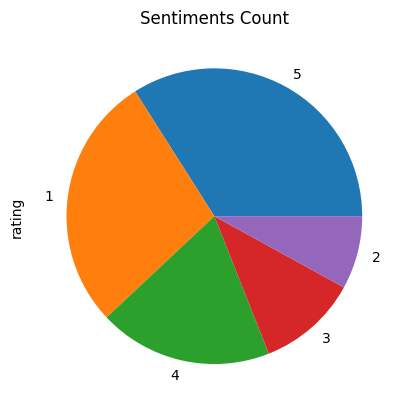

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Assuming you have the model and tokenizer defined
# model = ...
# tokenizer = ...

# Load data from CSV file
csv_file_path = '/content/Reviews.csv'
df = pd.read_csv(csv_file_path)

# Train and test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Define sentiment scoring function
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits)) + 1

# Apply sentiment_score function to valid reviews in the dataset
valid_predictions = df['reviewText'].apply(lambda x: sentiment_score(x[:512]) if isinstance(x, str) else None)

# Calculate accuracy
train_accuracy = (train_df['rating'] == valid_predictions.loc[train_df.index]).mean()
test_accuracy = (test_df['rating'] == valid_predictions.loc[test_df.index]).mean()

# Plot sentiments count
df['rating'].value_counts().plot(kind='pie')
plt.title('Sentiments Count')
plt.show()

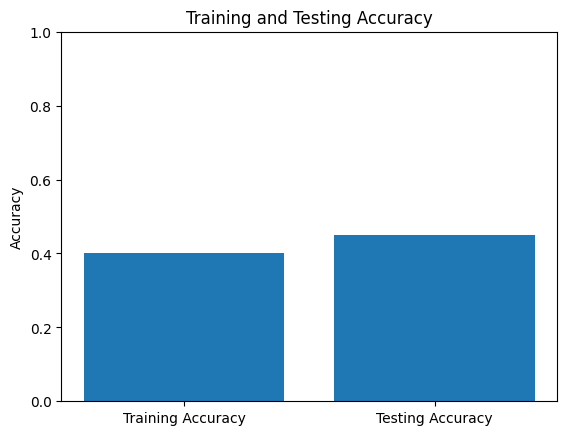

In [ ]:
# Combine accuracy and sentiment visualization
labels = ['Training Accuracy', 'Testing Accuracy']
accuracy = [train_accuracy, test_accuracy]

plt.bar(labels, accuracy)
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.title('Training and Testing Accuracy')
plt.ylabel('Accuracy')
plt.show()